Loading dataset from /content/drive/MyDrive/adhd_deepfmri_aal.npy...
Feature Engineering: Calculating Correlation Matrices...


100%|██████████| 637/637 [00:02<00:00, 218.09it/s]



--- Split Sizes ---
Train: 445, Val: 96, Test: 96

--- Starting Training ---
epoch 0  | loss: 1.51918 | train_auc: 0.4607  | train_accuracy: 0.56854 | train_logloss: 0.76508 | val_auc: 0.50926 | val_accuracy: 0.5625  | val_logloss: 0.76534 |  0:00:17s
epoch 1  | loss: 0.89815 | train_auc: 0.51521 | train_accuracy: 0.56629 | train_logloss: 0.68454 | val_auc: 0.64065 | val_accuracy: 0.5625  | val_logloss: 0.67892 |  0:00:29s
epoch 2  | loss: 0.90467 | train_auc: 0.51204 | train_accuracy: 0.56854 | train_logloss: 0.68392 | val_auc: 0.67769 | val_accuracy: 0.5625  | val_logloss: 0.68102 |  0:00:36s
epoch 3  | loss: 0.82958 | train_auc: 0.5022  | train_accuracy: 0.56854 | train_logloss: 0.68376 | val_auc: 0.59832 | val_accuracy: 0.5625  | val_logloss: 0.68261 |  0:00:45s
epoch 4  | loss: 0.80021 | train_auc: 0.48577 | train_accuracy: 0.56854 | train_logloss: 0.68423 | val_auc: 0.57055 | val_accuracy: 0.5625  | val_logloss: 0.6821  |  0:00:53s
epoch 5  | loss: 0.72506 | train_auc: 0.51947 |

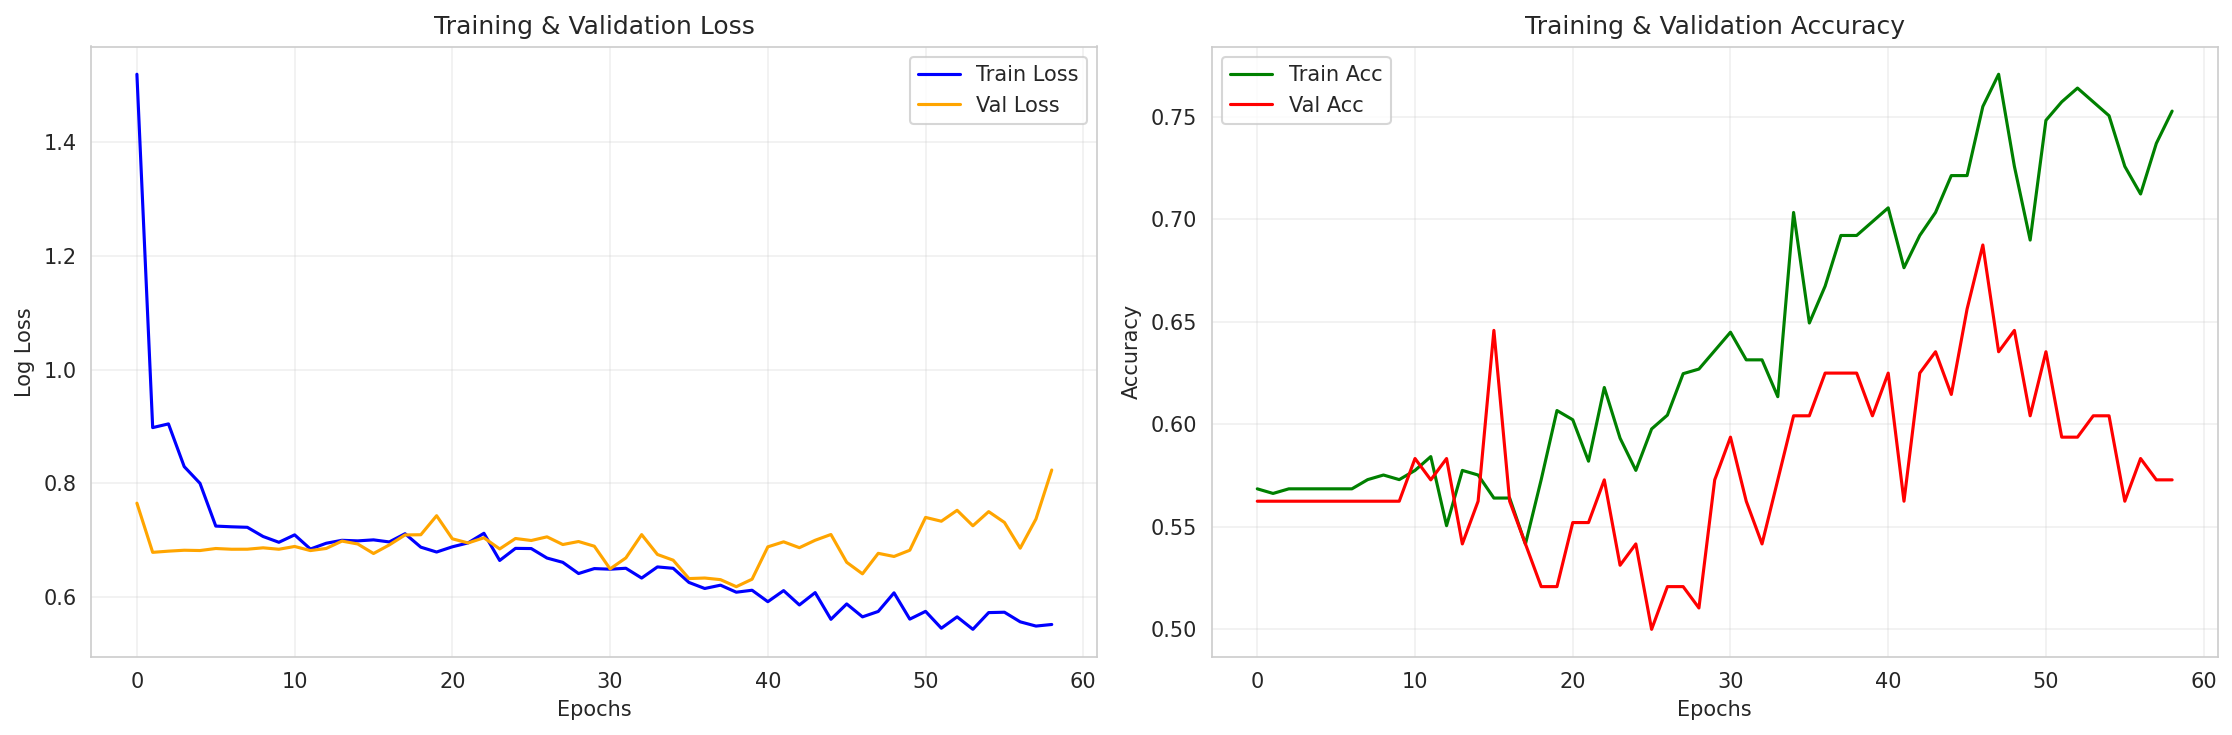

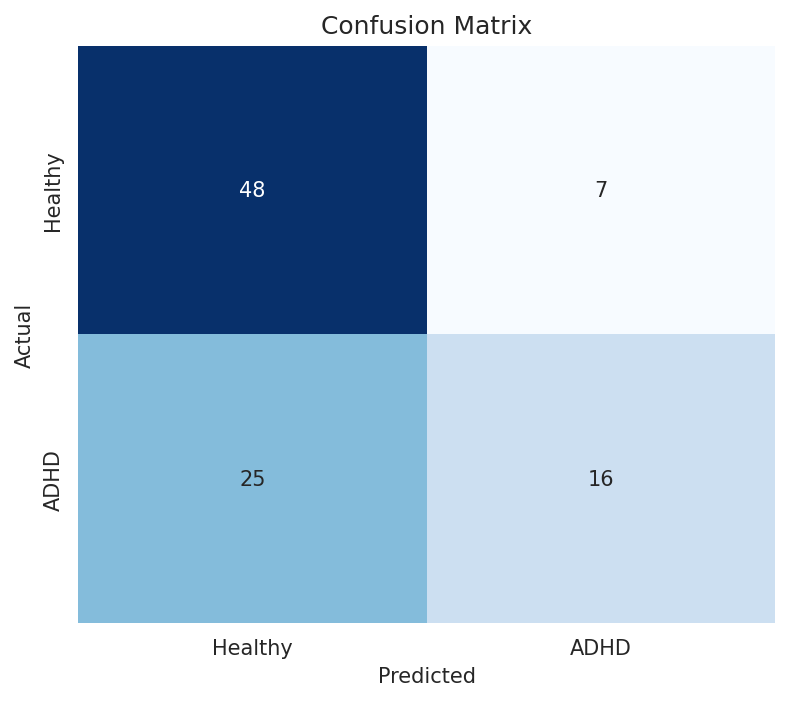

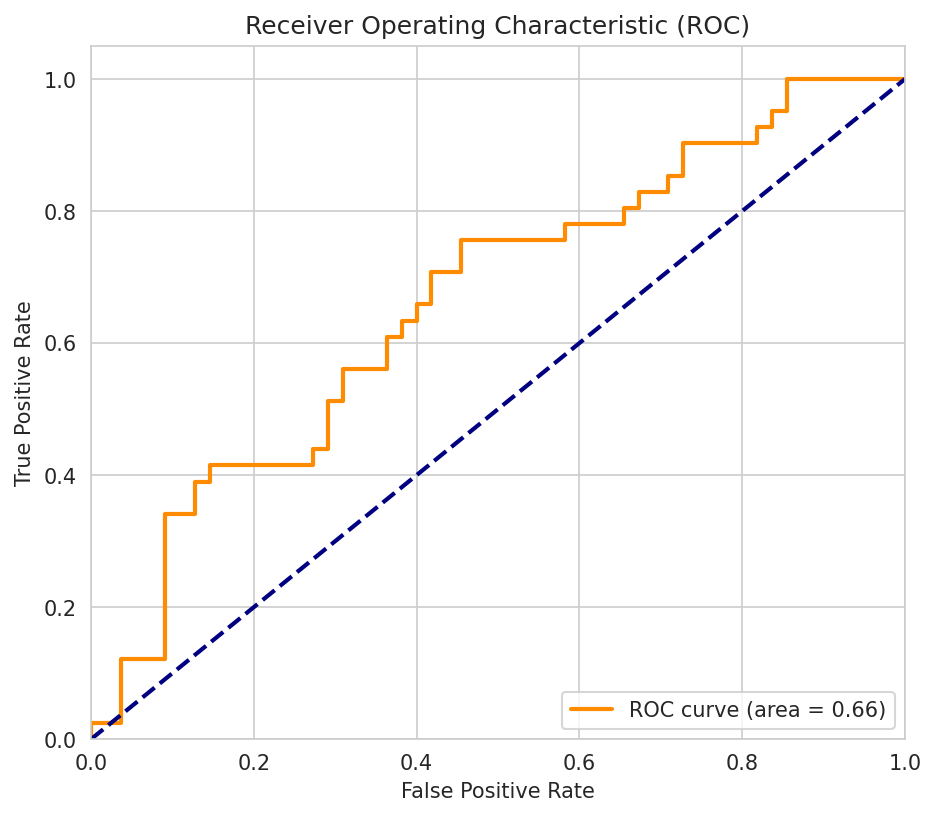


Top 10 Most Important Feature Indices: [4006  314 2582 2795 2608 2903   39 1422  923 2233]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# --- CONFIGURATION ---
DATA_PATH = '/content/drive/MyDrive/adhd_deepfmri_aal.npy'
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
MAX_EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 20
LEARNING_RATE = 2e-2

def load_and_preprocess_data(path):
    print(f"Loading dataset from {path}...")
    try:
        data = np.load(path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return None, None

    X_list = []
    y_list = []

    print("Feature Engineering: Calculating Correlation Matrices...")
    for subject in tqdm(data):
        # 1. Extract Time Series
        ts = subject['time_series']

        # 2. Pearson Correlation
        corr_matrix = np.corrcoef(ts.T)
        np.nan_to_num(corr_matrix, copy=False)

        # 3. Flatten Upper Triangle
        upper_tri_indices = np.triu_indices(corr_matrix.shape[0], k=1)
        connectivity_features = corr_matrix[upper_tri_indices]

        # 4. Phenotypes
        pheno = np.array(subject['pheno']).flatten()

        # 5. Fuse
        combined_features = np.concatenate([connectivity_features, pheno])

        X_list.append(combined_features)
        y_list.append(subject['label'])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)

    return X, y

def plot_training_history(history):
    """Plots Loss and Accuracy curves with safe key access."""
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Debug: Print available keys if needed
    # print("Available history keys:", history.history.keys())

    # --- 1. LOSS CURVE ---
    # Training loss is usually under key 'loss'
    if 'loss' in history.history:
        axs[0].plot(history['loss'], label='Train Loss', color='blue')

    # Validation loss: TabNet names it '{eval_name}_{metric}' -> 'val_logloss'
    if 'val_logloss' in history.history:
        axs[0].plot(history['val_logloss'], label='Val Loss', color='orange')
    elif 'val_loss' in history.history:
        axs[0].plot(history['val_loss'], label='Val Loss', color='orange')

    axs[0].set_title("Training & Validation Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Log Loss")
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # --- 2. ACCURACY CURVE ---
    # Keys will be 'train_accuracy' and 'val_accuracy'
    if 'train_accuracy' in history.history and 'val_accuracy' in history.history:
        axs[1].plot(history['train_accuracy'], label='Train Acc', color='green')
        axs[1].plot(history['val_accuracy'], label='Val Acc', color='red')
        axs[1].set_title("Training & Validation Accuracy")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Healthy', 'ADHD'], yticklabels=['Healthy', 'ADHD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def main():
    # 1. Load Data
    X, y = load_and_preprocess_data(DATA_PATH)
    if X is None: return

    # 2. Split Data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    val_share = VAL_SIZE / (1 - TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_share, random_state=RANDOM_STATE, stratify=y_temp
    )

    print(f"\n--- Split Sizes ---")
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    # 3. Calculate Class Weights (To fix low Recall)
    # This helps because you have more Healthy (0) than ADHD (1)
    # We pass this to the fit function via the `weights` parameter is NOT directly supported in all TabNet versions
    # straightforwardly for class balancing.
    # Instead, the reliable way in TabNet is to use a custom loss or rely on the architecture.
    # We will stick to standard training but with added 'logloss' metric.

    clf = TabNetClassifier(
        n_d=16, n_a=16,
        n_steps=5,
        gamma=1.3,
        n_independent=2, n_shared=2,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=LEARNING_RATE),
        scheduler_params={"step_size": 50, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        verbose=1
    )

    # 4. Train
    print("\n--- Starting Training ---")
    # CRITICAL FIX: Added 'logloss' to eval_metric so val_logloss is recorded
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'val'],
        eval_metric=['auc', 'accuracy', 'logloss'],
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        batch_size=BATCH_SIZE,
        virtual_batch_size=32,
        num_workers=0,
        drop_last=False
    )

    # 5. Evaluate
    print("\n--- Evaluation on Test Set ---")
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 6. Visualizations
    print("\n--- Generating Plots ---")
    plot_training_history(clf.history)
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_probs)

    # 7. Feature Importance
    feat_importances = clf.feature_importances_
    top_indices = np.argsort(feat_importances)[::-1][:10]
    print("\nTop 10 Most Important Feature Indices:", top_indices)

if __name__ == "__main__":
    main()